# Close nitrate budget to understand nitrate movement

In [1]:
import os,sys
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
from scipy.io import loadmat,savemat
from datetime import datetime


import h5py


In [ ]:
# Load data
prefix = ''

#Advection
FLUXrf = xr.open_dataset(prefix + '_2014_ADVrNO3.nc')
FLUXxf = xr.open_dataset(prefix + '_2016_ADVxNO3.nc')
FLUXyf = xr.open_dataset(prefix + '_2016_ADVyNO3.nc')

#Diffusion
DIFFrf = xr.open_dataset(prefix + '_2016_DFrINO3.nc')
DIFFxf = xr.open_dataset(prefix + '_2016_DFxENO3.nc')
DIFFyf = xr.open_dataset(prefix + '_2016_DFyENO3.nc')

#Biological flux
BLGf = xr.open_dataset(prefix + '_2016_BLGBION.nc')

#Radiative forcing
FORCf = xr.open_dataset(prefix + '_2016_ForcNO3.nc')

#Current
Uvelf = xr.open_dataset(prefix + '_2016_Snaps_Uvel.nc')
Vvelf = xr.open_dataset(prefix + '_2016_Snaps_Vvel.nc')
Wvelf = xr.open_dataset(prefix + '_2016_Snaps_Wvel.nc')

#Nitrate
WNO3f = xr.open_dataset(prefix + '_2016_WNO3.nc')
NO3f = xr.open_dataset(prefix + '_2016_Snaps_NO3.nc')

In [4]:
#Load grid files
mat = '/data/SO2/RedSea/GRID/grid.mat'
grid = {}
f = h5py.File(mat)
for k, v in f.items():
    grid[k] = np.array(v)
    #print(k)
print(grid.keys())

<ipython-input-4-e91db212146d>:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(mat)


dict_keys(['DRC', 'DRF', 'DXC', 'DXG', 'DYC', 'DYG', 'Depth', 'RAS', 'RAW', 'RC', 'RF', 'XC', 'XG', 'YC', 'YG', 'aRAC', 'hFacC', 'hFacS', 'hFacW', 'maskInC', 'maskInS', 'maskInW', 'rLowC', 'rLowS', 'rLowW', 'x', 'y'])


In [5]:
# Fromat grid data

dt = 86400*5
nt = 72
XC = grid['XC'][0,:]
YC = grid['YC'][:,0]
RC = grid['RC'][0,:]
RAC = NO3f['rA'][:,:]
DYG = grid['DYG'][:,:]
DXG = grid['DXG'][:,:]
DRF = grid['DRF'][0,:]
hFacW = grid['hFacW'][:,:,:]
hFacC = grid['hFacC'][:,:,:]
hFacS = grid['hFacS'][:,:,:]

len_x = len(XC)
len_y = len(YC)
len_z = len(RC)

xel = np.arange(0,len_x-1, 1)
yel = np.arange(0,len_y-1, 1)
zel = np.arange(0,len_z-1, 1)

nx = len(xel)
ny = len(yel)
nz = len(zel)


In [6]:
#Create surface areas

volume = np.zeros((nz,ny,nx), '>f4')
AREAWEST = np.zeros((nz, ny, nx+1), '>f4')
AREASOUTH = np.zeros((nz, ny+1, nx), '>f4')
AREACELL = np.zeros((nz+1, ny, nx), '>f4')

for k in range(nz):
    volume[k,...] = (hFacC[k,yel[0]:yel[-1]+1,xel]*RAC[yel[0]:yel[-1]+1,xel].transpose()*DRF[k]).transpose()
    AREACELL[k,...]  = RAC[yel[0]:yel[-1]+1,xel[0]:xel[-1]+1]
    AREAWEST[k,...]  = DYG[yel,xel[0]:xel[-1]+2]*DRF[k]*hFacW[k,yel,xel[0]:xel[-1]+2]
    AREASOUTH[k,...] = DXG[yel[0]:yel[-1]+2,xel]*DRF[k]*hFacS[k,yel[0]:yel[-1]+2,xel].transpose()

In [7]:
#calculate nitrate change

DZ         = np.nan*np.ones((nz,ny,nx),'>f4')
DRF1       = np.nan*np.ones((nz,ny,nx),'>f4')
DRF        = DRF[:nz]
for kk in range(nz):
    DRF1[kk,...] = DRF[kk]
    DZ[kk,...]   = DRF[kk]*hFacC[k,yel[0]:yel[-1]+1,xel].transpose()
    
Tr = np.array(NO3f['TRAC04'][:,:,:,:])
dTrdt      = np.diff(Tr[:,zel[0]:zel[-1]+1,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1], axis = 0)/dt
print(np.shape(dTrdt))

(71, 49, 1999, 1999)


In [8]:
ADV_x      = np.nan*np.zeros((nz,ny,nx),'>f4')
ADV_y      = np.nan*np.zeros((nz,ny,nx),'>f4')
ADV_z      = np.nan*np.zeros((nz,ny,nx),'>f4')

DIV_x      = np.nan*np.zeros((nz,ny,nx),'>f4')
DIV_y      = np.nan*np.zeros((nz,ny,nx),'>f4')
DIV_z      = np.nan*np.zeros((nz,ny,nx),'>f4')
DIV_t = np.zeros((nt,nz,ny,nx), '>f4')

DIFF_x     = np.nan*np.zeros((nz,ny,nx),'>f4')
DIFF_y     = np.nan*np.zeros((nz,ny,nx),'>f4')
DIFF_z     = np.nan*np.zeros((nz,ny,nx),'>f4')
DIFF_n = np.zeros((nz,ny,nx), '>f4')

BIO        = np.nan*np.zeros((nz,ny,nx),'>f4')
# Aeolian Deposition

# Correction due to vertical advection (WTRAC06)
CORR       = np.zeros((nz,ny,nx),'>f4')
ADVcorr = np.zeros((nz,ny,nx),'>f4')
RES = np.zeros((nz,ny,nx), '>f4')
ADVn = np.zeros((nz,ny,nx), '>f4')
ADVx_int1 = []
ADVy_int1 = []
ADVz_int1 = []
DIFFx_int1 = []
DIFFy_int1 = []
DIFFz_int1 = []
BIO_int1 = []
ADVn_int1 = []
dTrdt_int1 = []


In [ ]:
for tt in range(nt):

    FLUXx      = np.array(FLUXxf['ADVxTr04'][tt,:,:,:])

    FLUXy      = np.array(FLUXyf['ADVyTr04'][tt,:,:,:])

    FLUXz      = np.array(FLUXrf['ADVrTr04'][tt,:,:,:])


    # - uptake + remin + sed (mol/m3/s)

    BIOf       = np.array(BLGf['BLGBION'][tt,:,:,:])

    DIFFx      = np.array(DIFFxf['DFxETr04'][tt,:,:,:])

    DIFFy      = np.array(DIFFyf['DFyETr04'][tt,:,:,:])

    DIFFz      = np.array(DIFFrf['DFrITr04'][tt,:,:,:])

    FORC       = np.array(FORCf['ForcTr04'][tt,:,:,:])



    fieldU     = np.array(Uvelf['UVEL'][tt,:,:,:])

    fieldV     = np.array(Vvelf['VVEL'][tt,:,:,:])

    fieldW     = np.array(Wvelf['WVEL'][tt,:,:,:])

    fieldCorr  = np.array(WNO3f['WTRAC04'][tt,:,:,:])
    
    # Advection (div(bar(u)*tr))
    ADV_x[...] = np.diff(FLUXx[zel[0]:zel[-1]+1,yel[0]:yel[-1]+1,xel[0]:xel[-1]+2],axis=2)/volume
    ADV_y[...] = np.diff(FLUXy[zel[0]:zel[-1]+1,yel[0]:yel[-1]+2,xel[0]:xel[-1]+1],axis=1)/volume
    ADV_z[...] = -np.diff(FLUXz[zel[0]:zel[-1]+2,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1],axis=0)/volume
    
    # Divergence (nabla.u) * tr
    U     = fieldU[zel[0]:zel[-1]+1,yel[0]:yel[-1]+1,xel[0]:xel[-1]+2]*AREAWEST
    V     = fieldV[zel[0]:zel[-1]+1,yel[0]:yel[-1]+2,xel[0]:xel[-1]+1]*AREASOUTH
    W     = fieldW[zel[0]:zel[-1]+2,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1]*AREACELL
    W[0,...] = 0
    
    # gradients:
    print(np.shape(DIV_y),np.shape(np.diff(V[:,:,:], axis=1)), np.shape(volume[:,:,:]), np.shape(Tr[tt,zel[0]:zel[-1]+1,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1]))
    DIV_z[:,...]  = -1*((np.diff(W[:,:,:], axis = 0)/volume[:,...])*Tr[tt,zel[0]:zel[-1]+1,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1])
    DIV_y[:,:,:]  = (np.diff(V[:,:,:],axis = 1)/volume[:,:,:])*Tr[tt,zel[0]:zel[-1]+1,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1]
    DIV_x[...,:]  = (np.diff(U[:,:,:],axis = 2)/volume[...,:])*Tr[tt,zel[0]:zel[-1]+1,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1]
    
    # compute DIC*DIV_vec(U)
    DIV_t[...]  = DIV_x[...]+DIV_y[...]-DIV_z[...]
    ADVn[...] = ((-1*ADV_x[...])+(-1 * ADV_y[...])+(-1*ADV_z[...]))

    # Diffusion
    DIFF_x[...]  = np.diff(DIFFx[zel[0]:zel[-1]+1,yel[0]:yel[-1]+1,xel[0]:xel[-1]+2],axis=2)/volume
    DIFF_y[...]  = np.diff(DIFFy[zel[0]:zel[-1]+1,yel[0]:yel[-1]+2,xel[0]:xel[-1]+1],axis=1)/volume
    DIFF_z[...]  = -1*np.diff(DIFFz[zel[0]:zel[-1]+2,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1],axis=0)/volume

    DIFF_horiz  = (-1*DIFF_x[...]) + (-1*DIFF_y[...])
    DIFF        = DIFF_horiz + (-1*DIFF_z[...] )
    DIFF_n[...]       = DIFF
    
    # Biological term
    BIO[...] = BIOf[zel[0]:zel[-1]+1,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1]
    
    # Aeolian deposition
    #DEPO[tt,...] = FORC[zel[0]:zel[-1]+1,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1]
    
    # correction to vertical advection at z=0
    CORR[0,...] = fieldCorr[0,yel[0]:yel[-1]+1,xel[0]:xel[-1]+1]/DZ[0,...]
    
    # remove correction from advection:
    ADVcorr[...] = ADVn[...] - CORR[...]

    ADVx_int1.append(np.nansum(ADV_x[:8,1200:1550,:]*volume[:8,1200:1550,:]))
    ADVy_int1.append(np.nansum(ADV_y[:8,1200:1550,:]*volume[:8,1200:1550,:]))
    ADVz_int1.append(np.nansum(ADV_z[:8,1200:1550,:]*volume[:8,1200:1550,:]))
    DIFFx_int1.append(np.nansum(DIFF_x[:8,1200:1550,:]*volume[:8,1200:1550,:]))
    DIFFy_int1.append(np.nansum(DIFF_y[:8,1200:1550,:]*volume[:8,1200:1550,:]))
    DIFFz_int1.append(np.nansum(DIFF_z[:8,1200:1550,:]*volume[:8,1200:1550,:]))
    BIO_int1.append(np.nansum(BIO[:8,1200:1550,:]*volume[:8,1200:1550,:]))
    dTrdt_int1.append(np.nansum(dTrdt[tt,:8,1200:1550,:]*volume[:8,1200:1550,:]))
    ADVn_int1.append(np.nansum(ADVcorr[:8,1200:1550,:]*volume[:8,1200:1550,:]))

    print(int(tt/nt))
   

In [10]:
ADVz_int1 = -1*np.array(ADVz_int1)
ADVy_int1 = -1*np.array(ADVy_int1)
ADVx_int1 = -1*np.array(ADVx_int1)
DIFFz_int1 = -1*np.array(DIFFz_int1)
DIFFy_int1 = -1*np.array(DIFFy_int1)
DIFFx_int1 = -1*np.array(DIFFx_int1)
BIO_int1 = np.array(BIO_int1)
dTrdt_int1 = np.array(dTrdt_int1)
ADVcorr_int1 = np.array(ADVn_int1)

In [64]:
print(NO3f['time'][0:2])

<xarray.DataArray 'time' (time: 2)>
array(['2015-01-06T00:00:00.000000000', '2015-01-11T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    iter     (time) int64 ...
  * time     (time) datetime64[ns] 2015-01-06 2015-01-11
Attributes:
    standard_name:  time
    long_name:      Time
    axis:           T


[-8.56131775e+02 -3.14400116e+02  2.92460388e+02  3.09269085e+01
  5.85686096e+02 -1.63368286e+03 -4.62124084e+02  9.40684875e+02
 -1.04219116e+03  4.15942932e+02  1.50705872e+03  2.46794205e+02
  3.38725281e+02  4.93873688e+02 -1.04035263e+02  5.38719299e+02
 -5.23592651e+02  1.00208167e+03 -4.16427460e+02  1.75411758e+02
  1.54059436e+03 -4.61288452e-01  8.19656738e+02  1.32783545e+03
  8.58426453e+02  4.48106689e+01 -1.05835251e+02 -3.21169586e+01
 -1.01298688e+03  1.03578514e+02 -4.21886230e+02  8.36841278e+01
 -6.78602539e+02  4.97958130e+02 -4.11340271e+02  4.95966187e+01
 -2.42170883e+02 -8.90397263e+01  7.49061661e+01  8.32351761e+01
 -9.78650391e+02  6.99309082e+02  5.75436211e+00  4.99664154e+02
 -2.30001099e+02  8.51901245e+00 -1.57595932e+02  7.67676697e+01
  2.76013733e+02 -9.71740662e+02  4.76169662e+01 -7.62384033e+01
 -5.69601318e+02 -2.95023193e+02 -2.56580994e+02  9.42215729e+01
 -1.31403122e+02 -2.70025146e+02 -1.60533279e+02 -3.04812592e+02
  3.64201538e+02 -4.47548

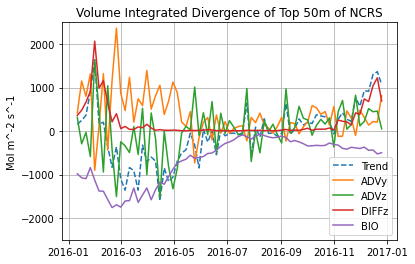

In [19]:


print(ADVz_int1*-1)
plt.plot(NO3f['time'][1:], dTrdt_int1, linestyle = '--', linewidth=1.5)
plt.plot(NO3f['time'][1:],ADVy_int1[1:])
plt.plot(NO3f['time'][1:],ADVz_int1[1:])
#plt.plot(NO3f['time'][1:],DIFFx_int1[1:])
#plt.plot(NO3f['time'][1:],DIFFy_int1[1:])
plt.plot(NO3f['time'][1:],DIFFz_int1[1:])
plt.plot(NO3f['time'][1:],BIO_int1[1:])
plt.legend([ 'Trend', 'ADVy', 'ADVz','DIFFz', 'BIO'])
plt.grid(True)
#plt.plot(NO3f['time'][1:], np.zeros(72), linestyle = '--', color = 'grey')
plt.ylabel('Mol m^-2 s^-1')
plt.title('Volume Integrated Divergence of Top 50m of NCRS')
plt.ylim([-2500, 2500])
plt.savefig('figures/Volume_Integrated_Divergence_top50_ncrs16.png', bbox_inches = 'tight')

In [12]:
data_array = np.ones((9,71))
data_array[0,:] = ADVx_int1[1:]
data_array[1,:] = ADVy_int1[1:]
data_array[2,:] = ADVz_int1[1:]
data_array[3,:] = DIFFx_int1[1:]
data_array[4,:] = DIFFy_int1[1:]
data_array[5,:] = DIFFz_int1[1:]
data_array[6,:] = BIO_int1[1:]
data_array[7,:] = dTrdt_int1[:]
data_array[8,:] = ADVcorr_int1[:]
np.savetxt('/data/SO2/RedSea/WORK/panaylor/budget_ints_run2_2016.csv', data_array)

In [22]:
data_15 = np.loadtxt('/data/SO2/RedSea/WORK/panaylor/budget_ints_run2_2015.csv')
data_1516 = np.concatenate((data_15, data_array), 1)
no3_15 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/ARCHIVE/RedSea_Run2_5day_2015_NO3.nc')
no3_16 = xr.open_dataset('/data/SOSE/SOSE/RedSea/OUTPUT/ARCHIVE/RedSea_Run2_5day_2016_NO3.nc')
time = np.concatenate((np.array(no3_15['time'][1:]), np.array(no3_16['time'][1:])))
print(np.shape(data_1516))

(9, 143)


[-8.56131775e+02 -3.14400116e+02  2.92460388e+02  3.09269085e+01
  5.85686096e+02 -1.63368286e+03 -4.62124084e+02  9.40684875e+02
 -1.04219116e+03  4.15942932e+02  1.50705872e+03  2.46794205e+02
  3.38725281e+02  4.93873688e+02 -1.04035263e+02  5.38719299e+02
 -5.23592651e+02  1.00208167e+03 -4.16427460e+02  1.75411758e+02
  1.54059436e+03 -4.61288452e-01  8.19656738e+02  1.32783545e+03
  8.58426453e+02  4.48106689e+01 -1.05835251e+02 -3.21169586e+01
 -1.01298688e+03  1.03578514e+02 -4.21886230e+02  8.36841278e+01
 -6.78602539e+02  4.97958130e+02 -4.11340271e+02  4.95966187e+01
 -2.42170883e+02 -8.90397263e+01  7.49061661e+01  8.32351761e+01
 -9.78650391e+02  6.99309082e+02  5.75436211e+00  4.99664154e+02
 -2.30001099e+02  8.51901245e+00 -1.57595932e+02  7.67676697e+01
  2.76013733e+02 -9.71740662e+02  4.76169662e+01 -7.62384033e+01
 -5.69601318e+02 -2.95023193e+02 -2.56580994e+02  9.42215729e+01
 -1.31403122e+02 -2.70025146e+02 -1.60533279e+02 -3.04812592e+02
  3.64201538e+02 -4.47548

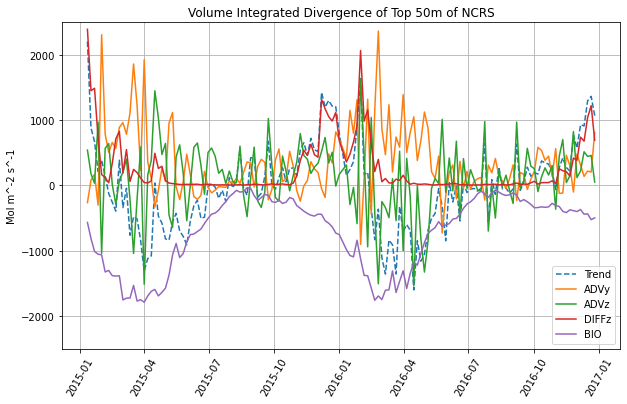

In [26]:
print(ADVz_int1*-1)
plt.figure(figsize=(10,6))
plt.plot(time, data_1516[7,:], linestyle = '--', linewidth=1.5)
plt.plot(time,data_1516[1,:])
plt.plot(time,data_1516[2,:])
#plt.plot(NO3f['time'][1:],DIFFx_int1[1:])
#plt.plot(NO3f['time'][1:],DIFFy_int1[1:])
plt.plot(time,data_1516[5,:])
plt.plot(time,data_1516[6,:])
plt.legend([ 'Trend', 'ADVy', 'ADVz','DIFFz', 'BIO'])
plt.grid(True)
#plt.plot(NO3f['time'][1:], np.zeros(72), linestyle = '--', color = 'grey')
plt.ylabel('Mol m^-2 s^-1')
plt.title('Volume Integrated Divergence of Top 50m of NCRS')
plt.ylim([-2500, 2500])
plt.xticks(rotation=60)
plt.savefig('figures/Volume_Integrated_Divergence_top50_ncrs1516.png', bbox_inches = 'tight')

[-8.56131775e+02 -3.14400116e+02  2.92460388e+02  3.09269085e+01
  5.85686096e+02 -1.63368286e+03 -4.62124084e+02  9.40684875e+02
 -1.04219116e+03  4.15942932e+02  1.50705872e+03  2.46794205e+02
  3.38725281e+02  4.93873688e+02 -1.04035263e+02  5.38719299e+02
 -5.23592651e+02  1.00208167e+03 -4.16427460e+02  1.75411758e+02
  1.54059436e+03 -4.61288452e-01  8.19656738e+02  1.32783545e+03
  8.58426453e+02  4.48106689e+01 -1.05835251e+02 -3.21169586e+01
 -1.01298688e+03  1.03578514e+02 -4.21886230e+02  8.36841278e+01
 -6.78602539e+02  4.97958130e+02 -4.11340271e+02  4.95966187e+01
 -2.42170883e+02 -8.90397263e+01  7.49061661e+01  8.32351761e+01
 -9.78650391e+02  6.99309082e+02  5.75436211e+00  4.99664154e+02
 -2.30001099e+02  8.51901245e+00 -1.57595932e+02  7.67676697e+01
  2.76013733e+02 -9.71740662e+02  4.76169662e+01 -7.62384033e+01
 -5.69601318e+02 -2.95023193e+02 -2.56580994e+02  9.42215729e+01
 -1.31403122e+02 -2.70025146e+02 -1.60533279e+02 -3.04812592e+02
  3.64201538e+02 -4.47548

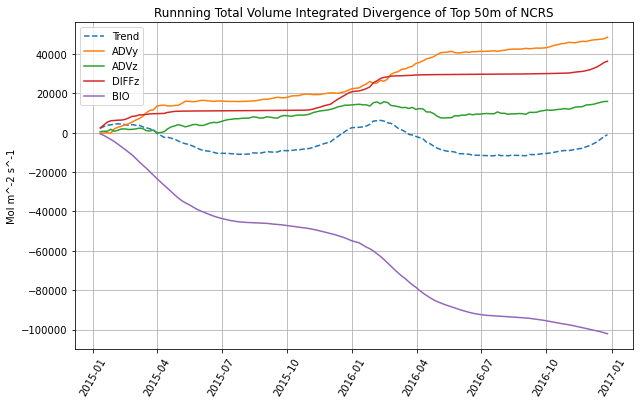

In [29]:
print(ADVz_int1*-1)
plt.figure(figsize=(10,6))
plt.plot(time, np.cumsum(data_1516[7,:]), linestyle = '--', linewidth=1.5)
plt.plot(time,np.cumsum(data_1516[1,:]))
plt.plot(time,np.cumsum(data_1516[2,:]))
#plt.plot(NO3f['time'][1:],DIFFx_int1[1:])
#plt.plot(NO3f['time'][1:],DIFFy_int1[1:])
plt.plot(time,np.cumsum(data_1516[5,:]))
plt.plot(time,np.cumsum(data_1516[6,:]))
plt.legend([ 'Trend', 'ADVy', 'ADVz','DIFFz', 'BIO'])
plt.grid(True)
#plt.plot(NO3f['time'][1:], np.zeros(72), linestyle = '--', color = 'grey')
plt.ylabel('Mol m^-2 s^-1')
plt.title('Runnning Total Volume Integrated Divergence of Top 50m of NCRS')
#plt.ylim([-2500, 2500])
plt.xticks(rotation=60)
plt.savefig('figures/Volume_Integrated_Divergence_top50_ncrs1516_cum.png', bbox_inches = 'tight')

In [ ]:
save_dir = '/data/SO2/RedSea/WORK/panaylor/'
ADV_dict = {'ADVcorr': -1*ADVcorr, 'ADV_z': -1*ADV_z, 'ADV_x': -1*ADV_x, 'ADV_y': -1*ADV_y}
DIFF_dict = {'DIFF_n': DIFF_n, 'DIFF_z': -1*DIFF_z, 'DIFF_x': -1*DIFF_x, 'DIFF_y': -1*DIFF_y}
BIO_dict = {'BIO': BIO}
trend_dict = {'Trend': dTrdt}
savemat((save_dir + 'budget_terms_run2_2015_ADV.mat'), ADV_dict, '-v7.3')
savemat((save_dir+'budget_terms_run2_2015_DIFF.mat'), DIFF_dict, '-v7.3')
savemat((save_dir+'budget_term_run2_2015_BIO.mat'), BIO_dict, '-v7.3')
savemat((save_dir+'budget_term_run2_2015_Trend.mat'), Trend_dict, '-v7.3')

#savemat('budget_divs_run2_2015', save_dict, '-v7.3')